# 3D Shape Detection using MobilenetV1

The following jupyter notebook outlines the procedure of training a Deep Neural Network with MobileNetV1 as the base model and using transfer learning to classify between images of Cubes and Cylinders.

## Importing the pretrained MobileNetV1 model and 3D-Shape dataset

In [2]:
# Download 3D-shape dataset zip
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/3D_Shapes.zip -O 3D_Shapes.zip

--2024-03-22 14:48:47--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/3D_Shapes.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.62.116, 16.12.40.3, 52.219.158.115, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.62.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2137601 (2.0M) [application/zip]
Saving to: ‘3D_Shapes.zip’

3D_Shapes.zip       100%[===================>]   2.04M  1.59MB/s    in 1.3s    

2024-03-22 14:48:49 (1.59 MB/s) - ‘3D_Shapes.zip’ saved [2137601/2137601]



In [3]:
# Download pretrained model
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/mobilenet_v1.zip -O mobilenet_v1.zip

--2024-03-22 14:48:58--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/mobilenet_v1.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.160.159, 16.12.36.143, 52.219.160.115, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.160.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9263 (9.0K) [application/zip]
Saving to: ‘mobilenet_v1.zip’

mobilenet_v1.zip    100%[===================>]   9.05K  --.-KB/s    in 0s      

2024-03-22 14:48:59 (55.5 MB/s) - ‘mobilenet_v1.zip’ saved [9263/9263]



In [5]:
# Unzip dataset
import zipfile as zf
files = zf.ZipFile("3D_Shapes.zip", 'r')
files.extractall('3D_Shapes_Dataset')
files.close()

The dataset consists of examples for *cube, cylinder, spheroid and sphere*. However we only need cubes and cylinders therefore other two folders are deleted.

In [8]:
!rm -r /content/3D_Shapes_Dataset/sphere

rm: cannot remove '/content/3D_Shapes_Dataset/sphere': No such file or directory


In [9]:
!rm -r /content/3D_Shapes_Dataset/shperoid

In [10]:
# Unzip mobilenet
files = zf.ZipFile("mobilenet_v1.zip", 'r')
files.extractall('mobilenet_v1')
files.close()

## Import Tensorflow and other modules

In [15]:
from tensorflow import keras
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten
import matplotlib.pyplot as plt
import cv2

from mobilenet_v1.mobilenet import MobileNet

from tensorflow.keras.applications.mobilenet import preprocess_input

In [11]:
# Model Hyper-parameters
IMAGE_SIZE = 224
ALPHA=0.75
EPOCHS=20

## Preprocess image for training

In [12]:
# Preprocess according to mobilenet requirements
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

## Build model

In [13]:
# Function to build transfer learning base model
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x)

    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

In [16]:
# Instantiate MobileNetV1 as the base model
base_model=MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE,3), alpha = ALPHA,
                     depth_multiplier = 1, dropout = 0.001, include_top = False,
                     weights = "imagenet", classes = 2, backend=keras.backend,
                     layers=keras.layers,models=keras.models,utils=keras.utils)

10626956/10626956 [==============================] - 0s 0us/step


In [20]:
# Set model parameters
FC_LAYERS = [100, 50]
dropout = 0.5

# Build final model
model = build_finetune_model(base_model,
                                      dropout=dropout,
                                      fc_layers=FC_LAYERS,
                                      num_classes=2)

## Make dataflow pipeline

In [21]:
# Instantiate data generator (Pipeline)
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

# Create data pipeline from directory
train_generator=train_datagen.flow_from_directory('3D_Shapes_Dataset',
                                                 target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical', shuffle=True)

Found 600 images belonging to 2 classes.


## Display model structure

In [22]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 226, 226, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 24)      648       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 24)      96        
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 24)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 24)      216       
 )                                                         

## Train model

In [23]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size
history = model.fit_generator(generator=train_generator,steps_per_epoch=step_size_train,epochs=EPOCHS, shuffle=True)

model.save('model.h5')

<ipython-input-23-2ed376c28c10>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,steps_per_epoch=step_size_train,epochs=EPOCHS, shuffle=True)


Epoch 1/20
18/18 [==============================] - 30s 2s/step - loss: 0.7280 - accuracy: 0.6250
Epoch 2/20
18/18 [==============================] - 21s 1s/step - loss: 0.3988 - accuracy: 0.8099
Epoch 3/20
18/18 [==============================] - 18s 1s/step - loss: 0.2124 - accuracy: 0.9444
Epoch 4/20
18/18 [==============================] - 18s 1s/step - loss: 0.0818 - accuracy: 0.9842
Epoch 5/20
18/18 [==============================] - 18s 1s/step - loss: 0.0541 - accuracy: 0.9912
Epoch 6/20
18/18 [==============================] - 19s 986ms/step - loss: 0.0394 - accuracy: 0.9894
Epoch 7/20
18/18 [==============================] - 17s 934ms/step - loss: 0.0340 - accuracy: 0.9912
Epoch 8/20
18/18 [==============================] - 16s 901ms/step - loss: 0.0224 - accuracy: 0.9965
Epoch 9/20
18/18 [==============================] - 17s 915ms/step - loss: 0.0218 - accuracy: 0.9947
Epoch 10/20
18/18 [==============================] - 17s 932ms/step - loss: 0.0118 - accuracy: 0.9982
Epoc

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Plot the loss and metrics

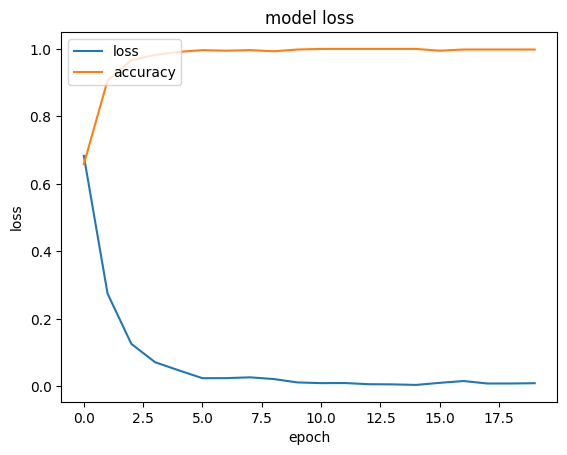

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

## Prediction

In [ ]:
def predict_shape(img_path):
    preprocessed_image = prepare_image(img_path)
    predictions_shape = model.predict(preprocessed_image)
    print(predictions_shape)
    labels=['Cube','Cylinder']
    img=cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    print("Shape Detected: ", labels[predictions_shape[0].tolist().index(max(predictions_shape[0]))])